<a href="https://colab.research.google.com/github/camilorey/repositorio_poligran/blob/master/informe_repo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# El código que subyace al Dashboard

A continuación sigue el código que es necesario para que el Dashboard funcione.

In [66]:
params_db={'hostname':'kashin.db.elephantsql.com',
           'username':'rvsmzhyg',
           'password':'k_WJ12u1EYzXngB2uj2LLE9TtzOhd-FB',
           'database':'rvsmzhyg'}

def hacer_query(query,insert=False):
    conexionDB = None
    resultado = None
    try:
        conexionDB = psycopg2.connect(host=params_db['hostname'],
                                      user=params_db['username'],
                                      password=params_db['password'],
                                      dbname=params_db['database'])
        resultado = pd.read_sql_query(query, conexionDB)
        if insert == True:
              conexionDB.commit()
        conexionDB.close()
        return resultado
    except (Exception, psycopg2.DatabaseError) as Error:
        print(Error)
    finally:
        if conexionDB is not None:
          conexionDB.close()
          #print("DB Connection closed", "OK")

In [9]:
def get_info_tabla_basica(nom_tabla):
  query = "SELECT * FROM <nom_tabla>"
  q = query.replace('<nom_tabla>',nom_tabla)
  return hacer_query(q)

In [31]:
def datos_barras(nom_variable):
  query_prods_tipos = "SELECT * FROM producto_proyecto_grupo_tipo_prod;"
  prods_tipos = hacer_query(query_prods_tipos)
  grupos = get_info_tabla_basica(nom_variable)
  pivote_prods = pd.pivot_table(prods_tipos,index=nom_variable,
                                values='producto',aggfunc='count')
  prods_grupo = grupos[[nom_variable]].set_index(nom_variable).join(pivote_prods,how='outer').reset_index()
  prods_grupo = prods_grupo.sort_values(by=nom_variable,ascending=True)
  prods_grupo = prods_grupo.fillna(0)
  return prods_grupo

def barras_variable(nom_variable,subfig,paleta='Blues_d'):
  datos = datos_barras(nom_variable)
  g = sns.barplot(y=nom_variable, x="producto", hue="producto", 
            data=datos,ax=subfig,palette=paleta)
  g.legend_.remove()

In [64]:
def poner_metas(proy):
  return metas_proyectos[proy]

def crear_evaluacion_metas(metas_proyectos):
  metas = datos_barras('proyecto')
  metas['meta'] = 1
  metas['meta'] = metas['proyecto'].apply(lambda p: poner_metas(p))
  metas['diferencia'] = metas['producto']-metas['meta']
  metas['dif_porcentual'] = 100*metas['diferencia']/metas['meta']
  return metas

def grafica_metas(var,metas_proyecto,subfig):
  estado_proyectos = crear_evaluacion_metas(metas_proyecto)
  g = sns.barplot(y='proyecto', x=var, hue=var, 
            data=estado_proyectos,ax=subfig,palette='coolwarm')
  g.legend_.remove()

  def grafica_personas(subfig):
  personas = hacer_query("SELECT * FROM productividad_personas")
  g = sns.barplot(y='persona', x='num_productos', hue='num_productos', 
            data=personas[0:5],ax=subfig,palette='Greens_r')
  g.legend_.remove()

# Este es un borrador de Dashboard

A continuación mostramos cómo se podría hacer una suerte de Dashboard para visualizar el estado de productos de investigación en relación con proyectos, grupos y personas.

In [59]:
metas_proyectos ={'proyecto 1':4,'proyecto 2':2,'proyecto 3':3,
                  'proyecto 4': 1,'proyecto 5': 3,'proyecto 6':1,
                  'proyecto 7': 2,'proyecto 8':2,'proyecto 9':1}

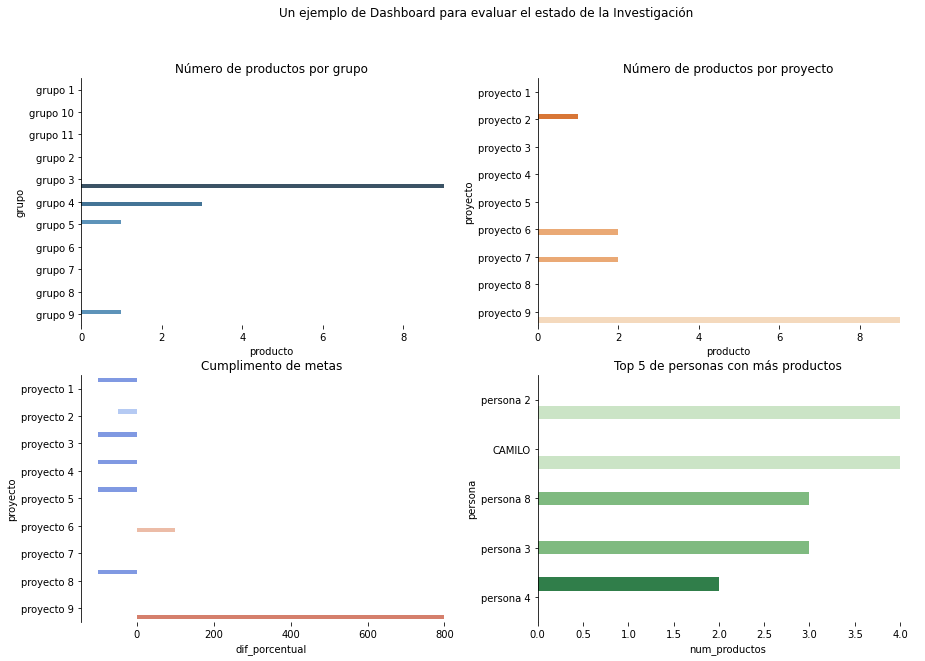

In [70]:
fig,subfig = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Un ejemplo de Dashboard para evaluar el estado de la Investigación')
subfig[0,0].set_title('Número de productos por grupo')
barras_variable('grupo',subfig[0,0],paleta='Blues_d')
subfig[0,1].set_title('Número de productos por proyecto')
barras_variable('proyecto',subfig[0,1],paleta='Oranges_r')
subfig[1,0].set_title('Cumplimento de metas')
grafica_metas('dif_porcentual',metas_proyectos,subfig[1,0])
subfig[1,1].set_title('Top 5 de personas con más productos')
grafica_personas(subfig[1,1])
sns.despine(bottom=True)
plt.show()